# Цель лабораторной работы:
Изучение ансамблей моделей машинного обучения.

# Задание:
1. Выбрать набор данных (датасет) для решения задачи классификации или регресии.
2. В случае необходимости провести удаление или заполнение пропусков и кодирование категориальных признаков.
3. С использованием метода train_test_split разделить выборку на обучающую и тестовую.
4. Обучить две ансамблевые модели. Оценить качество моделей с помощью одной из подходящих для задачи метрик. Сравнить качество полученных моделей.


# 1. Импорт библиотек и данных

In [817]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/housing-in-london/housing_in_london_monthly_variables.csv
/kaggle/input/housing-in-london/housing_in_london_yearly_variables.csv


In [818]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="ticks")
plt.rcParams['figure.dpi']= 150

# 2. Характеристики датасета
Для выполнения лабораторной работы был выбран датасет Housing in London, который содержит информацию о рынке недвижости в Лондоне. На данном датасете решается задача регрессии: количество проданных домов на основе других признаков.

**Датасет содержит следующие признаки:**

    date - временной интервал, который характеризует запись
    area - район, по которому представлены данные
    average_price - средняя цена жилья
    code - код район
    houses_sold - количество проданного жилья
    no_of_crimes - количество совершенных преступлений
    borough_flag - булева переменная для обозначения, является ли район боро Лондона.
    

In [819]:
# Импорт датасета
houses = pd.read_csv('/kaggle/input/housing-in-london/housing_in_london_monthly_variables.csv', sep=",")

In [820]:
# Первые 5 строк датасета
houses.head()

,date,area,average_price,code,houses_sold,no_of_crimes,borough_flag
0,1995-01-01,city of london,91449,E09000001,17.0,NaN,1
1,1995-02-01,city of london,82203,E09000001,7.0,NaN,1
2,1995-03-01,city of london,79121,E09000001,14.0,NaN,1
3,1995-04-01,city of london,77101,E09000001,7.0,NaN,1
4,1995-05-01,city of london,84409,E09000001,10.0,NaN,1


In [821]:
# Статистические характеристики признаков
houses.describe()

,average_price,houses_sold,no_of_crimes,borough_flag
count,1.354900e+04,13455.000000,7439.000000,13549.000000
mean,2.635197e+05,3893.994129,2158.352063,0.733338
std,1.876175e+05,12114.402476,902.087742,0.442230
min,4.072200e+04,2.000000,0.000000,0.000000
25%,1.323800e+05,247.000000,1623.000000,0.000000
50%,2.229190e+05,371.000000,2132.000000,1.000000
75%,3.368430e+05,3146.000000,2582.000000,1.000000
max,1.463378e+06,132163.000000,7461.000000,1.000000


# 3. Поиск и обработка пропусков
Исследуем датасет на наличие пропусков. Проведем заполненение и удаление пропусков в зависимости от признака. 

In [822]:
# Импорт библиотеки визуализации пропусков
import missingno as msno

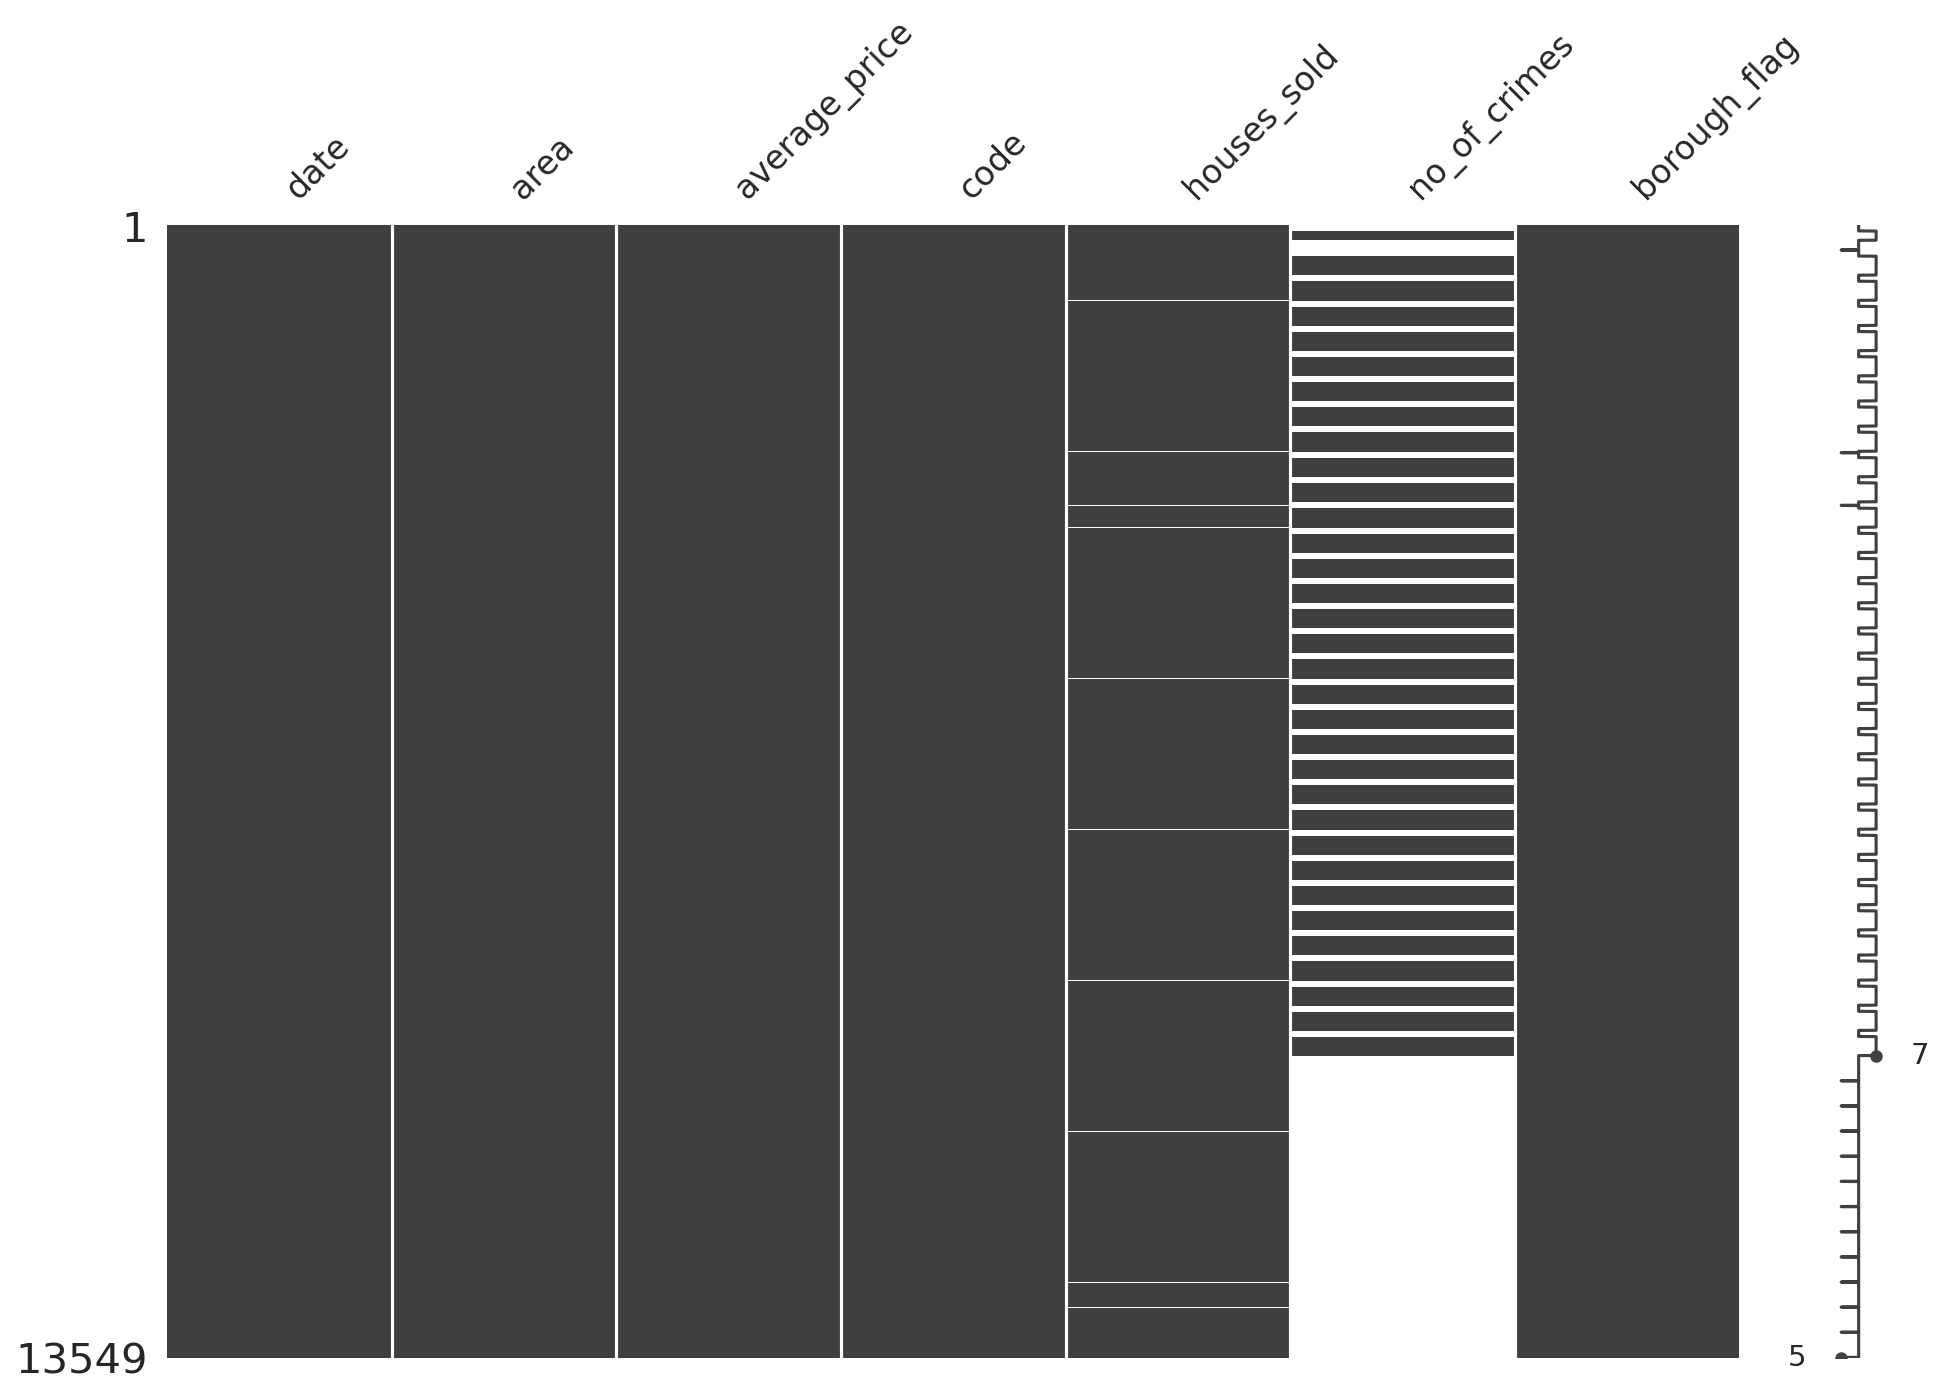

In [823]:
# Построение матрицы пропусков
msno.matrix(houses,figsize=(15,10))

Как видно из матрицы заполнения признаков, отстутсвует достаточно много значений у признака *no_of_crimes* и несколько значений признака *houses_sold*. Проверим коррелирует ли наличие/отсутстствие одного признака с другим.

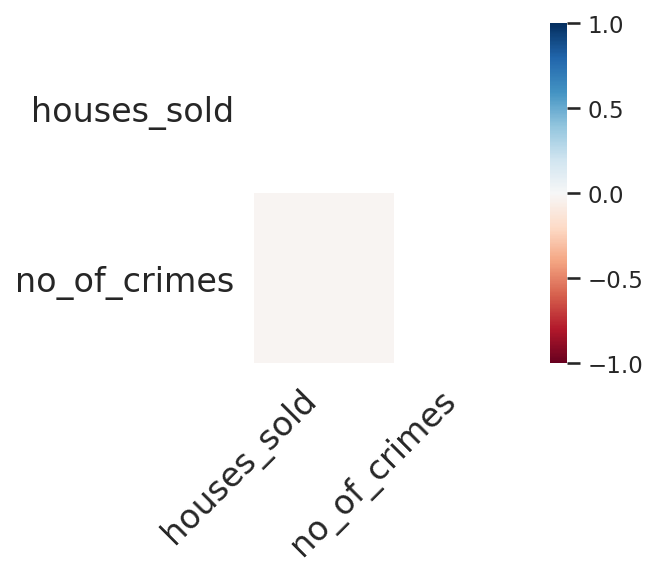

In [824]:
# Построение матрицы корреляции у признаков с пропусками
msno.heatmap(houses,figsize=(3,3))

Как видно из корреляционой матрицы нулевое значение корреляции обозначает, что не наблюдается взаимосвязи между отсутствием/присутствием одного признака с другим. 

In [825]:
# Функция подсчета числа пропусков и процента от всех значений 
def compute_missing_values(df):
    #total number of missing values
    total_missing = df.isnull().sum().sort_values(ascending=False)
    
    #calculating the percentage of missing values
    percentage_missing = (100 * df.isnull().sum() / len(df))
    
    #Missing values table - total, percentage
    table_missing = pd.concat([total_missing, percentage_missing], axis = 1, 
                              keys = ['Число пропущенных значений', 'Процент пропущенных значений'])
    
    #Filtering the columns with missing values
    table_missing = table_missing[table_missing.iloc[:, 0] != 0]
    
    return table_missing

In [826]:
houses_missing_values = compute_missing_values(houses)
houses_missing_values.style.background_gradient(cmap='Reds')

,Число пропущенных значений,Процент пропущенных значений
no_of_crimes,6110,45.095579
houses_sold,94,0.693778


Из таблицы видно что почти половина значений признака* no_of_crimes* отсутствует, у признака *houses_sold* отсутствует меньше процента значений. Выберем стратегии обработки пропусков

In [827]:
# Статистические характеристики признака no_of_crimes
houses['no_of_crimes'].describe()

count    7439.000000
mean     2158.352063
std       902.087742
min         0.000000
25%      1623.000000
50%      2132.000000
75%      2582.000000
max      7461.000000
Name: no_of_crimes, dtype: float64

Медианное значение у признака *no_of_crimes* близко к среднему, выберем медиану для  заполнения пропусков.

Что касается признака *houses_sold* удалим строки, в которых значения отстутсвуют, так как их количество незначительно.

In [828]:
# Обрабатываем пропуски в признаках no_of_crimes и houses_sold
houses['no_of_crimes'].fillna(houses['no_of_crimes'].median(), inplace=True)
houses = houses[houses['houses_sold'].notna()]

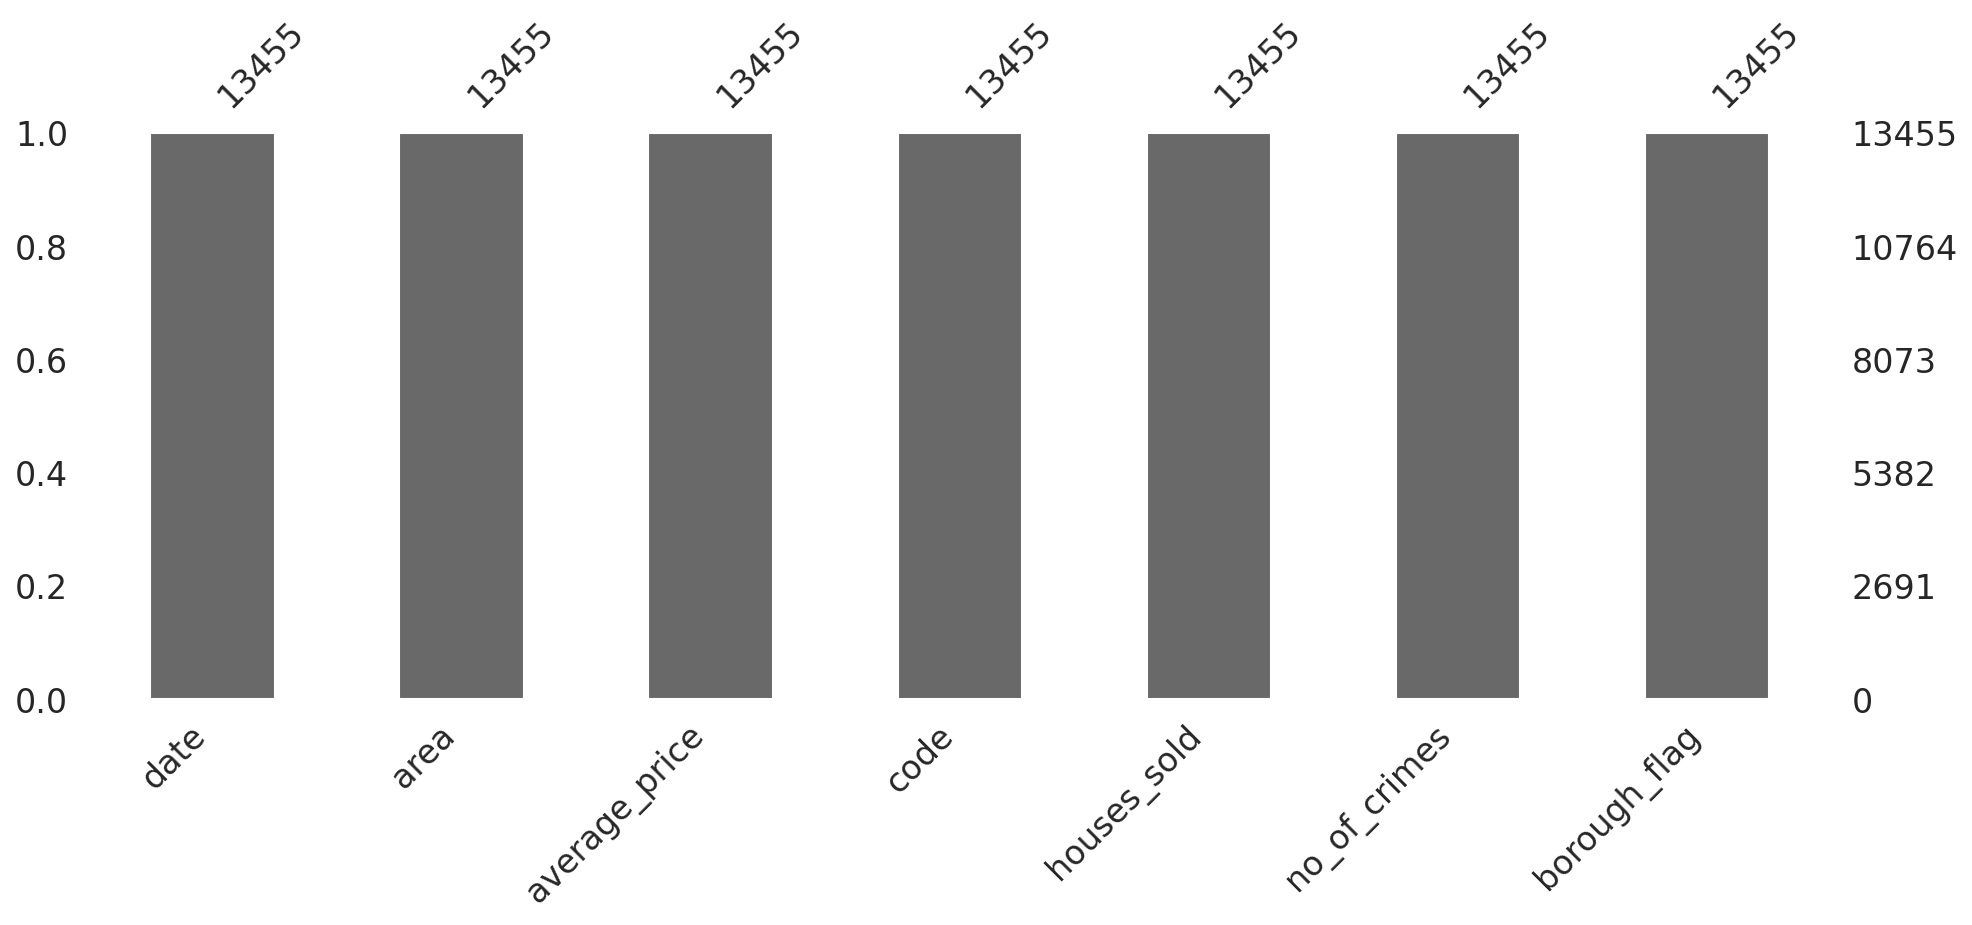

In [829]:
# Проверяем, что больше нет пропуском с помощью столбчатой диаграммы
msno.bar(houses,figsize=(15,5))

# 4. Обработка категориальных признаков
Далее обработуем категориальные признаки *area* и *code*. Исходя из датасета, эти признаки взаимосвязаны и обозначают одну и ту же часть города.

In [830]:
# Кодируем признаки area и code, заменяя из числами в порядке, представленном в датасете
area_le, area_classes = pd.factorize(houses['area'])
code_le, code_classes = pd.factorize(houses['code'])
code_classes,area_classes

(Index(['E09000001', 'E09000002', 'E09000003', 'E09000004', 'E09000005',
        'E09000006', 'E09000007', 'E09000008', 'E09000009', 'E09000010',
        'E09000030', 'E09000011', 'E09000012', 'E12000008', 'E09000013',
        'E09000014', 'E09000015', 'E09000016', 'E09000017', 'E09000018',
        'E09000019', 'E09000020', 'E09000021', 'E09000022', 'E09000023',
        'E09000024', 'E09000025', 'E09000026', 'E09000027', 'E09000028',
        'E09000029', 'E09000031', 'E09000032', 'E09000033', 'E13000001',
        'E13000002', 'E12000001', 'E12000002', 'E12000003', 'E12000004',
        'E12000005', 'E12000006', 'E12000007', 'E12000009', 'E92000001'],
       dtype='object'),
 Index(['city of london', 'barking and dagenham', 'barnet', 'bexley', 'brent',
        'bromley', 'camden', 'croydon', 'ealing', 'enfield', 'tower hamlets',
        'greenwich', 'hackney', 'south east', 'hammersmith and fulham',
        'haringey', 'harrow', 'havering', 'hillingdon', 'hounslow', 'islington',
        

In [831]:
# Изменяем признаки в самом датасете
houses['area']=area_le
houses['code']=code_le

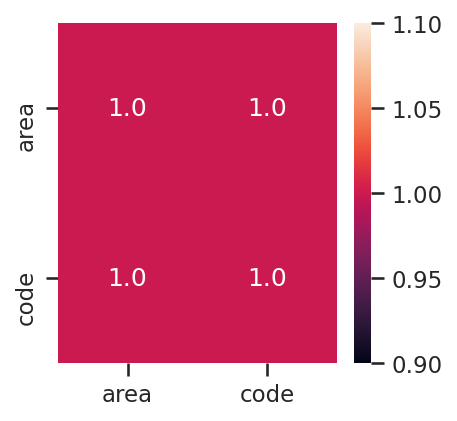

In [832]:
# Построим корреляционную матрицу для area и code
plt.figure(figsize=(3, 3))
sns.heatmap(houses[['area','code']].corr(),annot=True,fmt='.1f')

Как видно из матрицы эти признаки полностью зависимы, удалим признаки *area*, а также *date* для построения моделей.

In [833]:
# Удаляем признаки area и date
houses.drop(['code','date'], axis = 1, inplace=True)
houses

,area,average_price,houses_sold,no_of_crimes,borough_flag
0,0,91449,17.0,2132.0,1
1,0,82203,7.0,2132.0,1
2,0,79121,14.0,2132.0,1
3,0,77101,7.0,2132.0,1
4,0,84409,10.0,2132.0,1
...,...,...,...,...,...
13542,44,248562,70681.0,2132.0,0
13543,44,249432,75079.0,2132.0,0
13544,44,249942,64605.0,2132.0,0
13545,44,249376,68677.0,2132.0,0


# 5. Выбор целевого признака и трансформация данных

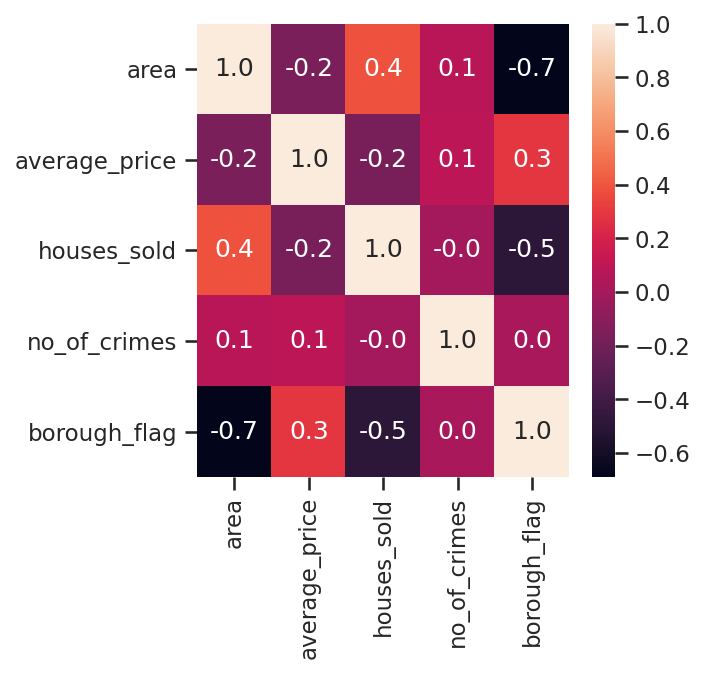

In [834]:
# Строим корреляционную матрицу для всех признаков.
plt.figure(figsize=(4, 4))
sns.heatmap(houses.corr(),annot=True,fmt='.1f')

Исходя из матрицы, можно сделать вывод, что признаки вцелом не обладают большой корреляцией. В качестве целевого выберем *houses_sold*, у которого наибольший показатель корреляции из матрицы (0.4 для признака *area*).

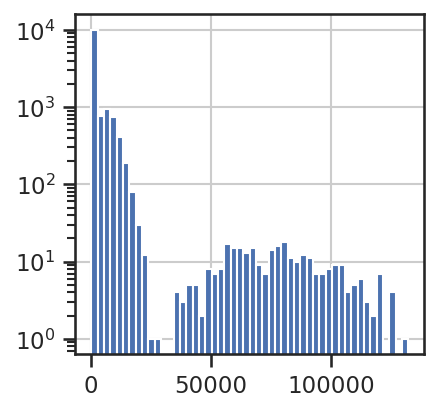

In [835]:
# Гистограмма признака houses_sold
ax = houses['houses_sold'].hist(bins=50,figsize=(3,3))
ax.set_yscale('log')

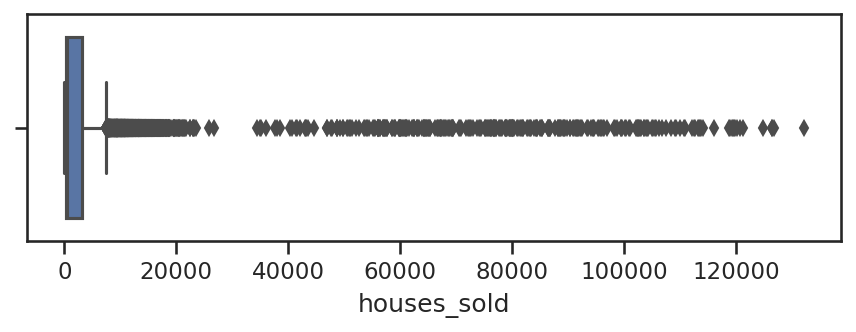

In [836]:
plt.figure(figsize=(7, 2))
sns.boxplot(houses['houses_sold'])

На диаграмме и ящике с усами видно, что у целевого признака присутсвуют достоточно много выбросов. Поэтому для трансформации данных применим RobustScaler, который предназначен для обработки данных с выбросами, используя для этого медиану и межквартильный размах.


In [837]:
# Импорт трансформатора из библиотеки
from sklearn.preprocessing import RobustScaler

In [838]:
# Применение RobustScaler на датасете
rs = RobustScaler()
houses[houses.columns] = rs.fit_transform(houses[houses.columns])
houses

,area,average_price,houses_sold,no_of_crimes,borough_flag
0,-1.0,-0.648276,-0.122111,0.0,0.0
1,-1.0,-0.694085,-0.125561,0.0,0.0
2,-1.0,-0.709355,-0.123146,0.0,0.0
3,-1.0,-0.719363,-0.125561,0.0,0.0
4,-1.0,-0.683155,-0.124526,0.0,0.0
...,...,...,...,...,...
13542,1.0,0.130140,24.253191,0.0,-1.0
13543,1.0,0.134450,25.770266,0.0,-1.0
13544,1.0,0.136977,22.157296,0.0,-1.0
13545,1.0,0.134173,23.561918,0.0,-1.0


# 6. Разделение переменных
Разделим выбранный целевой признак и входные признаки для построения моделей.

In [839]:
# Выделяем входные признаки
houses_X = houses.drop('houses_sold',axis=1)
houses_X

,area,average_price,no_of_crimes,borough_flag
0,-1.0,-0.648276,0.0,0.0
1,-1.0,-0.694085,0.0,0.0
2,-1.0,-0.709355,0.0,0.0
3,-1.0,-0.719363,0.0,0.0
4,-1.0,-0.683155,0.0,0.0
...,...,...,...,...
13542,1.0,0.130140,0.0,-1.0
13543,1.0,0.134450,0.0,-1.0
13544,1.0,0.136977,0.0,-1.0
13545,1.0,0.134173,0.0,-1.0


In [840]:
# Выделяем целевой признак
houses_y = houses['houses_sold']
houses_y

0        -0.122111
1        -0.125561
2        -0.123146
3        -0.125561
4        -0.124526
           ...    
13542    24.253191
13543    25.770266
13544    22.157296
13545    23.561918
13546    23.264229
Name: houses_sold, Length: 13455, dtype: float64

# 7. Подготовка функций для построения и сравнения моделей
Для построения моделей, сравнения их качества и вывода таблиц и графиков реализуем ряд функций.

In [841]:
# Вывод значения метрики для обучающего и тестового набора
def print_metric_scores(metrics,y_train,y_test,predict_y_train,predict_y_test):
    metrics_scores = {}
    for metric_name, metric in metrics.items():
        # Качество для обучающего набора
        train_score = metric(y_train, predict_y_train)
        print('метрика:', metric_name, '- обучающая выборка: ', train_score)
        metrics_scores[metric_name+'_train'] = train_score
        # Качество для тестового набора
        test_score = metric(y_test, predict_y_test)
        print('метрика:', metric_name, '- тестовая выборка: ', test_score)
        metrics_scores[metric_name+'_test'] = test_score
    return metrics_scores
        
# Обучение модели и вычисление целевого признака
def fit_predict(estimator, X_train, X_test, y_train):
    estimator.fit(X_train, y_train)
    target_train = estimator.predict(X_train)
    target_test = estimator.predict(X_test)
    return target_train,target_test
# Рассчет метрик для модели
def print_model_metrics(estimator, X_train, X_test, y_train, y_test, metrics):
    target_train,target_test = fit_predict(estimator,X_train,X_test,y_train)
    metrics_scores = print_metric_scores(metrics,y_train,y_test,target_train,target_test)
    return target_train,target_test,metrics_scores

In [842]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
# Функция для построения модели и вывода статистики
def build_print_model(X_train,X_test,y_train,y_test,estimator,model_name):
    
    class_metrics = {'mae':mean_absolute_error,'r2':r2_score}
    
    display('Значения метрик качества:')
    # Оценки качества по заданным метрикам
    pred_y_train, pred_y_test, scores = print_model_metrics(estimator,X_train,X_test,
                                                                    y_train,y_test,class_metrics)
    
    # Словарь характеристик модели
    stats = {'model_name': model_name}
    stats.update(scores)
    return stats

In [843]:
#Функция соединения словарей в один, значения каждого ключа в виде листов
def dict_zip(*dicts):
    return {k: [d[k] for d in dicts] for k in dicts[0].keys()}

In [844]:
# Вывод графиков для сравнения моделей
def print_models_plots(*stats):
    zip_model_data = dict_zip(*stats)
    df = pd.DataFrame(zip_model_data,index=zip_model_data['model_name'])
    display(df)
    df_plot = df.transpose().drop('model_name')
    # Выводим отдельные диаграммы для каждой оценки
    for i in range(df_plot.shape[0]//2):
        ax = df_plot.iloc[2*i:2*(i+1),:].plot(kind='barh',title=df_plot.index.values[2*i].split('_')[0],figsize=(4,4))
        for i in ax.patches:
            # get_width pulls left or right; get_y pushes up or down
            ax.text(0, i.get_y()+0.05, \
            str(round(i.get_width(), 4)), fontsize=8, color='white',weight = 'bold')
        ax.legend(bbox_to_anchor=(1.1, 1.05))

In [845]:
# Импорт функции разделения выборки
from sklearn.model_selection import train_test_split
from termcolor import colored
# Функция для построения и анализа моделей в цикле
def compare_models(X,y,etimators):
    # Разделение выборки на обучающую и тестовую
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)
    model_stats = []
    print(colored('Сравнение моделей', color='green'))
    for model_name,estimator in estimators.items():
        display('==================================================')
        print(colored(model_name, color='magenta'))
        if isinstance(estimator,Regressor):
            model_stat = build_print_model(X_train.to_numpy(), X_test.to_numpy(),
                                           y_train.to_numpy(), y_test.to_numpy(),estimator,model_name)
        else:
            model_stat = build_print_model(X_train, X_test, y_train, y_test,estimator,model_name)
        model_stats.append(model_stat)
    # Сравним качество моделей
    print_models_plots(*model_stats)

# 8. Построение и анализ моделей
В качестве ансамблевых моделей были выбраны **градиентный бустинг** и **МГУА** модель. 

Для сравнения были импортированы 3 различные реализации градиентного бустинга:
1. XGBRegressor из библиотеки xgboost
2. LGBMRegressor из библиотеки lightgbm
3. GradientBoostingRegressor из библиотеки sklearn

Для оценки качества были использованы метрики:
1. Средняя абсолютная ошибка
2. Коэффициент детерминации

In [846]:
# Импорт моделей градиентного бустинга
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [847]:
%%capture
# Установки библиотеки МГУА
!pip install --user git+git://github.com/kvoyager/GmdhPy.git

In [848]:
# Импорт МГУА регрессора из библиотеки
from gmdhpy.gmdh import Regressor

In [849]:
# Словарь моделей
estimators = {'XGBRegressor':XGBRegressor(),'LGBMRegressor':LGBMRegressor(),
             'GradientBoostingRegressor':GradientBoostingRegressor(),
             'GMDHRegressor':Regressor(ref_functions=('linear_cov', 'quadratic', 'cubic', 'linear'))}

Сравнение моделей


'=================================================='

XGBRegressor


'Значения метрик качества:'

метрика: mae - обучающая выборка:  0.08716062011484238
метрика: mae - тестовая выборка:  0.26542887847796204
метрика: r2 - обучающая выборка:  0.9980455733601177
метрика: r2 - тестовая выборка:  0.9364350569783982


'=================================================='

LGBMRegressor


'Значения метрик качества:'

метрика: mae - обучающая выборка:  0.2132195630285963
метрика: mae - тестовая выборка:  0.2551207527809474
метрика: r2 - обучающая выборка:  0.9585682811533867
метрика: r2 - тестовая выборка:  0.9399181368675965


'=================================================='

GradientBoostingRegressor


'Значения метрик качества:'

метрика: mae - обучающая выборка:  0.24107371478516698
метрика: mae - тестовая выборка:  0.283607395598041
метрика: r2 - обучающая выборка:  0.9706511500872302
метрика: r2 - тестовая выборка:  0.9422595952612032


'=================================================='

GMDHRegressor


'Значения метрик качества:'

train layer0 in 0.05 sec
train layer1 in 0.20 sec
train layer2 in 0.18 sec
train layer3 in 0.18 sec
train layer4 in 0.17 sec
train layer5 in 0.17 sec
train layer6 in 0.17 sec
train layer7 in 0.18 sec
train layer8 in 0.17 sec
train layer9 in 0.17 sec
train layer10 in 0.17 sec
train layer11 in 0.18 sec
train layer12 in 0.18 sec
train layer13 in 0.17 sec
train layer14 in 0.17 sec
train layer15 in 0.18 sec
train layer16 in 0.17 sec
train layer17 in 0.17 sec
train layer18 in 0.17 sec
train layer19 in 0.17 sec
train layer20 in 0.17 sec
train layer21 in 0.17 sec
train layer22 in 0.18 sec
train layer23 in 0.19 sec
train layer24 in 0.17 sec
train layer25 in 0.18 sec
train layer26 in 0.17 sec
train layer27 in 0.18 sec
метрика: mae - обучающая выборка:  0.33241799126336924
метрика: mae - тестовая выборка:  0.34217719922631834
метрика: r2 - обучающая выборка:  0.9375295936043746
метрика: r2 - тестовая выборка:  0.9228945364386836


,model_name,mae_train,mae_test,r2_train,r2_test
XGBRegressor,XGBRegressor,0.087161,0.265429,0.998046,0.936435
LGBMRegressor,LGBMRegressor,0.213220,0.255121,0.958568,0.939918
GradientBoostingRegressor,GradientBoostingRegressor,0.241074,0.283607,0.970651,0.942260
GMDHRegressor,GMDHRegressor,0.332418,0.342177,0.937530,0.922895


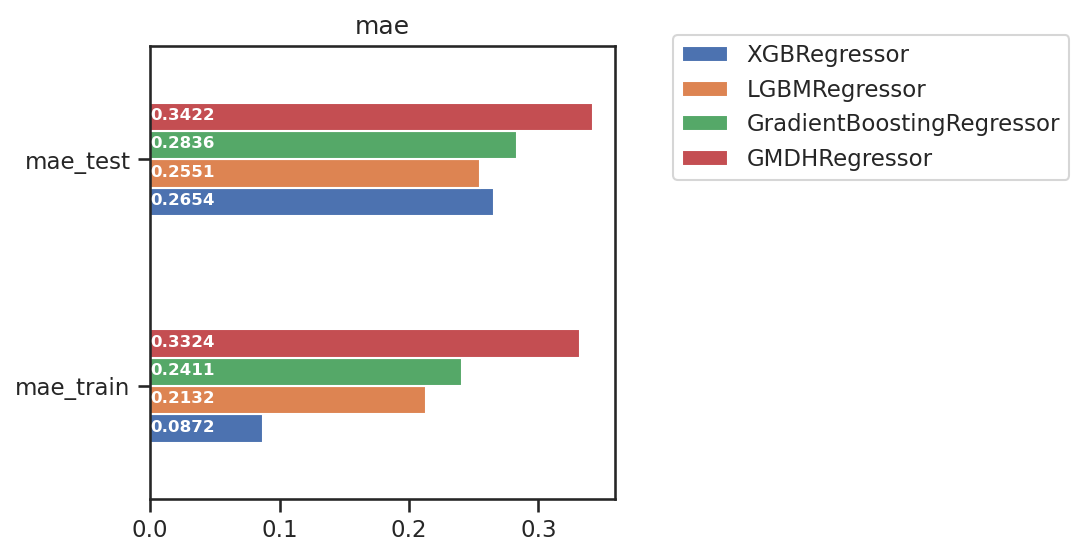

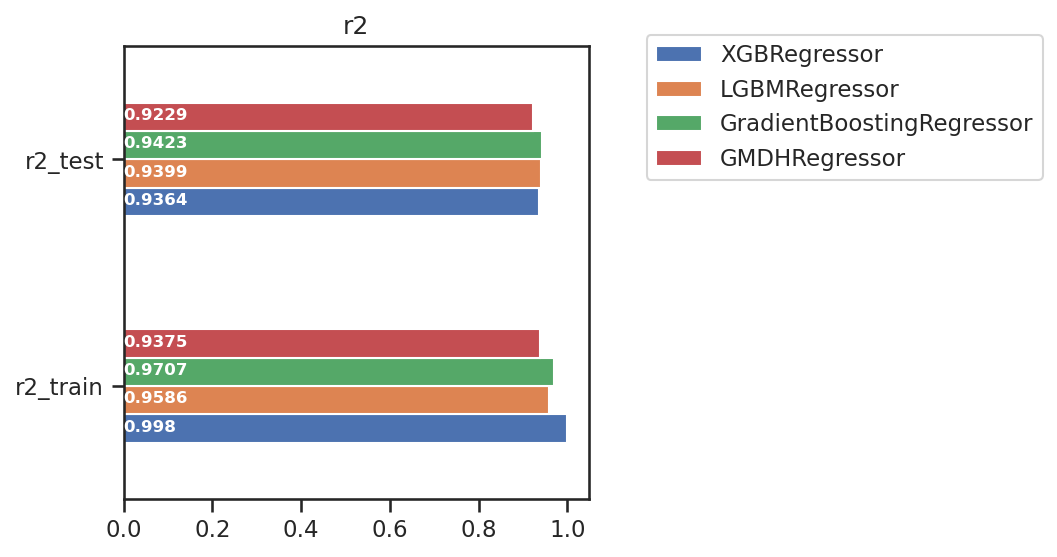

In [850]:
# Построение моделей и вывод оценок качества метрик
compare_models(houses_X,houses_y,estimators)

Исходя из результатов посроения моделей и оценок качества можно сделать вывод, что все модели обладают хорошим качеством.

Среди всех моделей самый высокий показатель на тренировочной выборки у модели **XGBRegressor**. Однако на тестовой выборки показатели у моделей **LGBMRegressor** и **GradientBoostingRegressor** выше. Таким образом, несмотря на лучшее качество на тренировочной выборки у **XGBRegressor** более всего наблюдается переобучение. 

Что касается **GMDHRegressor**, несмотря на то, что оценки качества у МГУА модели ниже, чем у всех моделей градиентного бустинга, разница между показателями на тестовой и тренировочной выборке наименьшая, что говорит о меньшей переобученности данной модели по сравнению с другими.


# 9. Вывод
В ходе лабораторной работы были исследованы ансамблевые модели. Был проведен анализ качества двух типов моделей на датасете, не обладающем заметной корреляцией.